In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from keras.engine import sequential
import numpy as np
from string import punctuation
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.layers as l
from sklearn.model_selection import train_test_split
import random


features_csv = pd.read_csv('features.csv')
labels_csv = pd.read_csv('lables.csv') # not labels
my_labels = np.array(labels_csv['Delta'].tolist())

tweets = features_csv['clean_text'].tolist()

for s in range(len(tweets)):
    # print(type(tweets[s]), type("\n"))
    tweets[s] = str(tweets[s]) + "\n"
    # print(s)
data = np.array(tweets)

prior_days = features_csv['five_prior_delta'].tolist()
pdays = []
#print(prior_days[0])
#context = features_csv.five_prior_delta.apply(pd.Series)
#context.columns = ["five", 'four', 'three', 'two', 'one']
#context = pd.DataFrame(prior_days, columns = ["five",'four','three','two','one'])
#context[['comments','likes','retweets','trading_day']] = features_csv[['Comments','Likes','Retweets','trading_day']]

#context.info()
for days in prior_days:
    string_days = days.strip('][').split(', ')
    for i in range(len(string_days)):
        string_days[i] = float(string_days[i])
    pdays.append(string_days)

context = np.array(pdays)


"""for i in range(data.shape[0]):
  data[i] = data[i].lower()
  # print(data[i])"""

all_text = ''.join([c for c in data if c not in punctuation])
# print(type(all_text))
reviews_split = all_text.split('\n')[0:-1]


all_text2 = ' '.join(reviews_split)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
# print("SPLITHERE", reviews_split)
sorted_words = count_words.most_common(total_words)

vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
# print(vocab_to_int)

reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
# print(type(reviews_int), reviews_int)
max_words = np.max(np.max(reviews_int))
# print(max_words)
max_len = 0
for review in reviews_int:
    if len(review) > max_len:
        max_len = len(review)
print(max_len)

reviews_len = [len(x) for x in reviews_int]
#pd.Series(reviews_len).hist()
#plt.show()
#pd.Series(reviews_len).describe()

# get rid of long and short reviews
# reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
# my_labels = [my_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]




def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features
features = np.array(pad_features(reviews_int, max_len))
len_feat = len(features)
my_labels = np.array(my_labels)


rs = random.randint(0,100)
print(features.shape, my_labels.shape)
train_x, test_x, train_y, test_y = train_test_split(features, my_labels, test_size=0.2, random_state=rs)
train_context, test_context, train_y, test_y = train_test_split(context, my_labels, test_size=0.2, random_state=rs)

from sklearn.preprocessing import QuantileTransformer,Normalizer, MinMaxScaler

norm = QuantileTransformer(output_distribution='normal')
train_context = norm.fit_transform(train_context)
test_context = norm.transform(test_context)
print(labels_csv.columns[0:2])
labels_csv.drop(labels_csv.columns[0:2], axis=1, inplace=True)



#labels_trans = MinMaxScaler()
#train_lbs, test_lbs = train_test_split(labels_csv, test_size=0.2, random_state=rs)

#train_y = labels_trans.fit_transform(train_lbs)
#test_y = labels_trans.transform(test_lbs)



train_x = train_x * 100
test_y = test_y * 100


'''
model = sequential()
model.add(Embedding(MAX_WORDS, OUTPUT_SIZE, input_length=example_length)) #(33,8,10)
model.add(LSTM)
model.add(dropout)
model.add(LSTM)
model.add(dropout)
# however many denses we want, concatenate with context model
dense
dropout
dense
compile
fit
evaluate
'''

print(train_x.shape, train_context.shape, train_y.shape)
print(test_x.shape, test_context.shape, test_y.shape)
# print(valid_x.shape, valid_context.shape, valid_y.shape)
in1 = l.Input(shape=[max_len])
in2 = l.Input(shape=[5])

# number of possible words, desired output shape, padded input length
m1 = l.Embedding(max_words, 8, input_length=max_len)(in1)
m1 = l.LSTM(4)(m1) # can be replaced with SimpleRNN
m1 = l.Dense(2, activation='relu')(m1)
m1 = l.BatchNormalization()(m1)
 
m2 = l.Dense(2, activation='relu')(in2)
m2 = l.BatchNormalization()(m2)

m = l.concatenate([m1,m2])
u = l.Dense(1, activation='tanh')(m)

model = k.Model(inputs=[in1, in2], outputs=u)

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit([train_x, train_context], train_y, validation_split=0.25, epochs=1, batch_size=10)
results = model.evaluate([test_x, test_context],test_y)
print("Results: ", results)

pred = model.predict([test_x, test_context])

#pred = y_scaler.inverse_transform(pred)

print('\n')
for item in pred:
  print(item)
print('\n')
for item in test_y:
  print(item)


C:\Users\ragop\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


104
(12205, 104) (12205,)
Index(['Unnamed: 0', 'Date'], dtype='object')
(9764, 104) (9764, 5) (9764,)
(2441, 104) (2441, 5) (2441,)
77/77 [==============================] - 0s 5ms/step - loss: 10.9813
Results:  10.981301307678223


[-0.00465921]
[-0.00107397]
[-0.00107397]
[0.00036552]
[-0.00107397]
[0.00152223]
[-0.00401448]
[-0.00044061]
[-0.00107397]
[-0.00107397]
[-0.00101117]
[-0.00107397]
[-0.01544205]
[0.00360063]
[-0.00107397]
[0.0002291]
[-0.00107397]
[-0.01080117]
[-0.00727709]
[0.00128369]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00392217]
[-0.00107397]
[-0.00419958]
[-0.00107397]
[-0.01992634]
[-0.00132907]
[-0.00107397]
[-0.00724861]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[-0.00181826]
[-0.00107397]
[-0.00107397]
[-0.00019513]
[-0.01916836]
[-0.00591451]
[-0.00512248]
[-0.0014681]
[-0.00107397]
[0.00098654]
[-0.00107397]
[-0.00107397]
[-0.00107397]
[0.000

In [3]:
train_df, test_df = train_test_split(
    features_csv,test_size=0.2, random_state=rs)


In [4]:
len(pred)

2441

In [5]:
test_df['pred'] = pred
test_df['actual'] = test_y

C:\Users\ragop\AppData\Local\Temp\ipykernel_11308\1955166005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = pred
C:\Users\ragop\AppData\Local\Temp\ipykernel_11308\1955166005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['actual'] = test_y


(array([   7.,   16.,  138.,  473., 1056.,  544.,   87.,   85.,   24.,
          11.]),
 array([-12.7897051 ,  -9.93270969,  -7.07571428,  -4.21871887,
         -1.36172346,   1.49527195,   4.35226736,   7.20926277,
         10.06625818,  12.92325359,  15.780249  ]),
 <BarContainer object of 10 artists>)

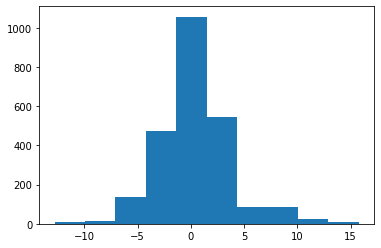

In [6]:
plt.hist(test_y)

(array([1.000e+00, 1.740e+02, 2.262e+03, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.04692358, -0.02784832, -0.00877306,  0.01030221,  0.02937747,
         0.04845273,  0.06752799,  0.08660326,  0.10567852,  0.12475379,
         0.14382905], dtype=float32),
 <BarContainer object of 10 artists>)

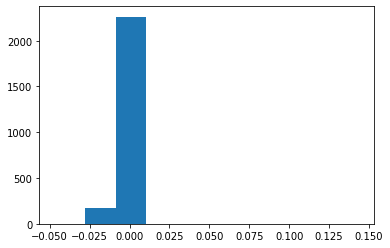

In [7]:
plt.hist(pred)

In [8]:
pd.options.display.max_colwidth = 1000

In [9]:
test_df.sort_values(by='pred', ascending=True).head(25)[['clean_text','pred','actual']]

,clean_text,pred,actual
8869,"replying to @akidesir and @kristennetten yeah, we could put in a setting allowing it to drop as low as 5%",-0.046924,-2.855576
7728,replying to @bbcsciencenews yes,-0.021405,0.783003
7350,replying to @jennerator211 we have n95 masks & getting paprs. will have our team reach out.,-0.020232,0.159134
7370,"replying to @samtwits @samtalkstesla and 3 others sigmoid (s-curve) is how all physical and mental viruses behave, regardless of containment. containment reduces asymptote of s-curve. at this point, we have strict containment in us/europe & should expect similarly reduced asymptote to china.",-0.020232,0.159134
7372,"replying to @flcnhvy @thirdrowtesla and @natesilver538 sigmoidal for china, followed by sigmoidal for rest of world",-0.020232,0.159134
7358,replying to @johnnacrider1 and @thirdrowtesla we’ll try to get & deliver as many as possible. n95 masks are a pain to wear btw. less onerous masks are better most of the time.,-0.020232,0.159134
7355,replying to @samtwits @samtalkstesla and 3 others no problem :),-0.020232,0.159134
4225,"replying to @insideevs @teslany and @tesla yes, it’s hard to find. not sure why.",-0.019926,-2.058017
8619,replying to @erdayastronaut @ppathole and @spacex we’re pretty close to the manufacturing size limit for a milled copper & steel jacket nozzle. lot of complexity to add a nozzle extension to a sea level engine for small gain. also hard to fit bigger engine nozzles on the booster.,-0.019168,2.714524
8608,"tesla model s & x have hospital-grade (hepa) air filters. 3 & y are really good too. this has a big effect on health. tesla.com putting the tesla hepa filter and bioweapon defense mode to the test */ air pollution has a significant and pervasive impact on public health. according to the world health organization, it is now considered ""the world's largest single environmental health risk,"" with...",-0.019168,2.714524
